In [1]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.9 MB/s eta 0:00:00


In [2]:
import math
import numpy
import pandas
import matplotlib.pyplot as plot
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
APPL = pandas.read_csv("/content/drive/MyDrive/Datasets/preprocessed_AAPL")
TESL = pandas.read_csv("/content/drive/MyDrive/Datasets/preprocessed_TSLA")
GOOG = pandas.read_csv("/content/drive/MyDrive/Datasets/preprocessed_GOOG")

A widely used statistical test is the Dickey-Fuller test. It can be used to ascertain whether the series has a unit root and to ascertain whether it is stationary.

**Null Hypothesis**: There is a unit root in the series.

**Another Hypothesis**: There isn't a unit root in the series.

The series is non-stationary if the Null Hypothesis is not rejected.

In [4]:
def dickey_fuller_test(series):
  output = adfuller(series['Adj Close'], autolag = 'AIC')
  print("Output of Dickey Fuller Test")
  print(f'Test Statistics: {output[0]}')
  print(f'p-value: {output[1]}')
  print(f'Number of lags used: {output[2]}')
  print(f'Number of observations used: {output[3]}')
  for key, value in output[4].items():
    print(f'critical value ({key}): {value}')

# Apple

In [5]:
APPL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,28.950001,29.082500,28.690001,29.037500,27.059303,115127600.0
1,2017-01-04,28.962500,29.127501,28.937500,29.004999,27.029022,84472400.0
2,2017-01-05,28.980000,29.215000,28.952499,29.152500,27.166470,88774400.0
3,2017-01-06,29.195000,29.540001,29.117500,29.477501,27.469332,127007600.0
4,2017-01-09,29.487499,29.857500,29.485001,29.747499,27.720936,134247600.0


In [6]:
APPL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1704 non-null   object 
 1   Open       1704 non-null   float64
 2   High       1704 non-null   float64
 3   Low        1704 non-null   float64
 4   Close      1704 non-null   float64
 5   Adj Close  1704 non-null   float64
 6   Volume     1704 non-null   float64
dtypes: float64(6), object(1)
memory usage: 93.3+ KB


In [7]:
# Change datatype of Date column
APPL["Date"] = pandas.to_datetime(APPL["Date"])

In [8]:
dickey_fuller_test(APPL)

Output of Dickey Fuller Test
Test Statistics: -0.5102493513290421
p-value: 0.8900008377025831
Number of lags used: 18
Number of observations used: 1685
critical value (1%): -3.4342368189880146
critical value (5%): -2.8632568111941152
critical value (10%): -2.5676839863871304


The test statistic of -0.5102 is greater than the critical values at the 1%, 5%, and 10% significance levels. This suggests that we fail to reject the null hypothesis.

To reduce the values' magnitude and the series' upward trend, let's now take the log of the "Adj Close" column.

Text(0.5, 1.0, 'Rolling Mean and Standard Deviation')

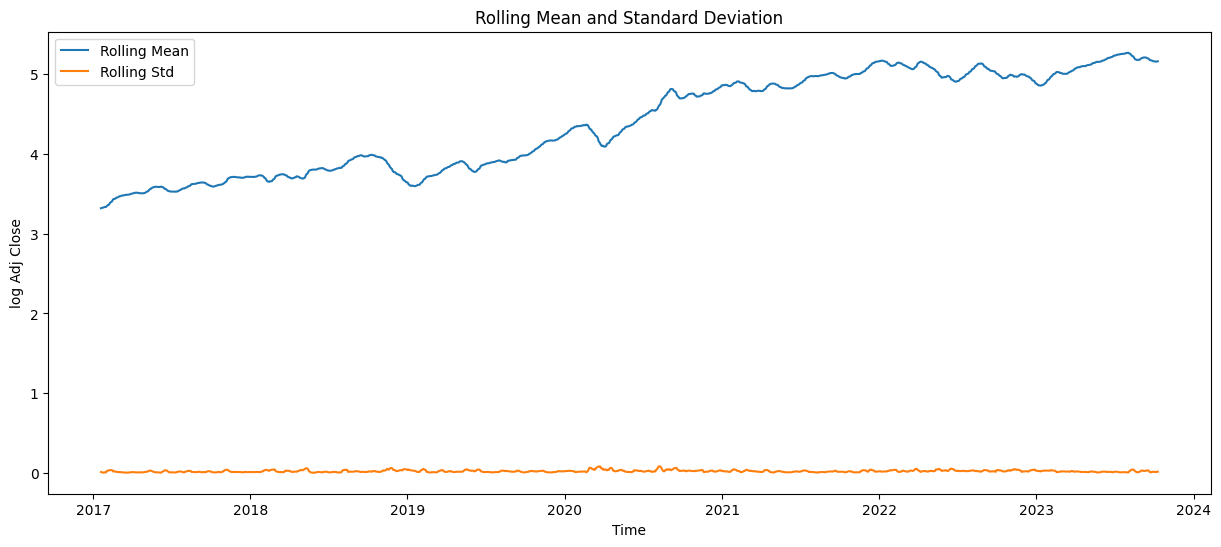

In [9]:
APPL['log Adj Close'] = numpy.log(APPL['Adj Close'])
APPL_log_moving_avg = APPL['log Adj Close'].rolling(12).mean()
APPL_log_std = APPL['log Adj Close'].rolling(12).std()

plot.figure(figsize = (15, 6))
plot.plot(APPL['Date'], APPL_log_moving_avg, label = "Rolling Mean")
plot.plot(APPL['Date'], APPL_log_std, label = "Rolling Std")
plot.xlabel('Time')
plot.ylabel('log Adj Close')
plot.legend(loc = 'best')
plot.title("Rolling Mean and Standard Deviation")

###Split the data into training and test set

    Training Period: 2017-01-01 - 2022-12-31

    Testing Period:  2022-01-01 - 2023-10-10

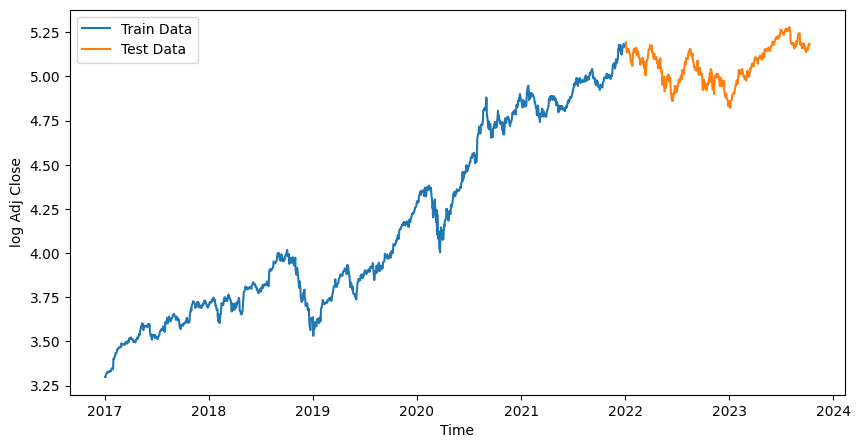

In [10]:
APPL_Train_Data = APPL[APPL['Date'] < '2022-01-01']
APPL_Test_Data = APPL[APPL['Date'] >= '2022-01-01'].reset_index(drop = True)

plot.figure(figsize = (10, 5))
plot.plot(APPL_Train_Data['Date'], APPL_Train_Data['log Adj Close'], label = 'Train Data')
plot.plot(APPL_Test_Data['Date'], APPL_Test_Data['log Adj Close'], label = 'Test Data')
plot.xlabel('Time')
plot.ylabel('log Adj Close')
plot.legend(loc = 'best')

###Modeling

In [11]:
APPL_Auto_ARIMA_Model = auto_arima(APPL_Train_Data['log Adj Close'], seasonal = False,
                                   error_action = 'ignore', suppress_warnings = True)
print(APPL_Auto_ARIMA_Model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1259
Model:               SARIMAX(2, 1, 1)   Log Likelihood                3202.016
Date:                Sat, 21 Oct 2023   AIC                          -6394.032
Time:                        03:30:00   BIC                          -6368.345
Sample:                             0   HQIC                         -6384.378
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0032      0.001      3.046      0.002       0.001       0.005
ar.L1         -1.0364      0.059    -17.666      0.000      -1.151      -0.921
ar.L2         -0.1466      0.016     -9.373      0.0

In [12]:

APPL_ARIMA_Model = sm.tsa.arima.ARIMA(APPL_Train_Data['log Adj Close'], order = (1, 1, 0))
APPL_ARIMA_Model_Fit = APPL_ARIMA_Model.fit()
print(APPL_ARIMA_Model_Fit.summary())

                               SARIMAX Results                                
Dep. Variable:          log Adj Close   No. Observations:                 1259
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3194.050
Date:                Sat, 21 Oct 2023   AIC                          -6384.100
Time:                        03:30:01   BIC                          -6373.826
Sample:                             0   HQIC                         -6380.239
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1229      0.016     -7.469      0.000      -0.155      -0.091
sigma2         0.0004   7.66e-06     47.639      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.03   Jarque-

###Predicting the closing stock price of Apple

<class 'pandas.core.series.Series'>


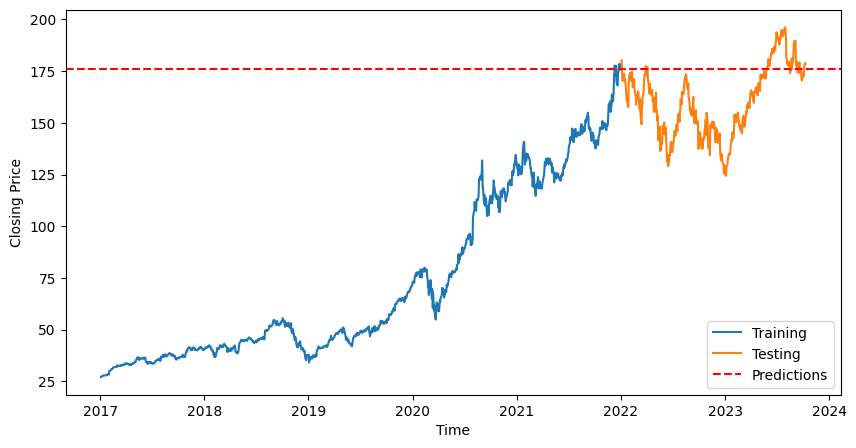

In [13]:
from collections import defaultdict
APPL_output=APPL_ARIMA_Model_Fit.forecast(102, alpha=0.05)
print(type(APPL_output))
APPL_predictions = numpy.exp(APPL_output.mean())
plot.figure(figsize=(10, 5))
plot.plot(APPL_Train_Data['Date'], APPL_Train_Data['Adj Close'], label = 'Training')
plot.plot(APPL_Test_Data['Date'], APPL_Test_Data['Adj Close'], label = 'Testing')
plot.axhline(y=APPL_predictions, color='r', linestyle='--', label='Predictions')
plot.xlabel('Time')
plot.ylabel('Closing Price')
plot.legend()

In [14]:
rmse = math.sqrt(mean_squared_error(APPL_Test_Data['Adj Close'], [APPL_predictions] * len(APPL_Test_Data)))
mape = numpy.mean(numpy.abs(APPL_predictions - APPL_Test_Data['Adj Close'])/numpy.abs(APPL_Test_Data['Adj Close']))

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 22.897999416261776
MAPE: 0.12655819633720025
